## Metric #1: Off-ice errors

Assume that the off-ice area has a ground truth of zero horizontal motion ($V = V_x = V_y = 0$), then we can calculate the difference between the feature tracking results and the ground truth (i.e. zero) over the off-ice area on an image, which could serve as a metric to evaluate the overall uncertainty of velocity values.

### Requirements and Limits

- There should be off-ice area in the source images. Works for mountain glaciers and outlet glaciers, but for ice sheet feature tracking it may be hard or impossible to find such the area. 
- Even though there are off-ice areas, this method may still fail if the off-ice pixels are decorrelated over time. A common reason for that is surface melt in the spring and snow accumulation in the fall.

### Procedure

1. Prepare the feature tracking results as Geotiff files, ideally $V_x$ as one file and $V_y$ as the other. The unit for pixel value is flexible, from pixels, pixels/day, pixels/year, to meters, meters/day, to meters/year. **In this notebook, all of the feature tracking data use meters/day as the unit of the pixel value.**

2. Locate off-ice area and make an ESRI shapefile (polygon format) for that. Future development includes the inverse selection of an RGI glacier outline as the off-ice area as well.

3. Use `gftt.off_ice_errors` and `gftt.plot_off_ice_errors` to calculate, analyze, and visualize the off-ice errors.

### Analysis

#### 1. Basic information, importing modules

- Test area: **Kaskawulsh Glacier**
- Test packages: **CARST, Vmap, GIV, autoRIFT**
- Test pair: **Landsat 8 20180304-20180405**

In [1]:
# Developer's setting
%load_ext autoreload
%autoreload 2

In [2]:
import glaft
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors, cm
from matplotlib.colors import ListedColormap
import rasterio
from rasterio.plot import show
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

#### 2. Load the feature tracking data list and off-ice area shapefile

Each row is a feature tracking test using a specific parameter combination described in each field.

In [3]:
df = pd.read_csv('../manifest.csv', dtype=str)
df

Date Duration (days) Template size (px)  \
0    Sen2-20180304-20180314              10                 48   
1    Sen2-20180304-20180314              10                 48   
2    Sen2-20180304-20180314              10                 48   
3    Sen2-20180304-20180314              10                 48   
4    Sen2-20180304-20180314              10                 48   
..                      ...             ...                ...   
167  Sen2-20180508-20180627              50                 64   
168  Sen2-20180508-20180627              50                 32   
169  Sen2-20180508-20180627              50                 32   
170  Sen2-20180508-20180627              50                 64   
171  Sen2-20180508-20180627              50                 64   

    Template size (m) Pixel spacing (px) Pixel spacing (m) Prefilter  \
0                 480                 12               120       Gau   
1                 480                 12               120      NAOF   
2                 480                 12               120      None   
3                 480                  1                10       Gau   
4                 480                  1                10      NAOF   
..                ...                ...               ...       ...   
167               640                  8                80       Gau   
168               320                  4                40      NAOF   
169               320                  8                80      NAOF   
170               640                  4                40      NAOF   
171               640                  8                80      NAOF   

                 Subpixel  Software  \
0    16-node oversampling     CARST   
1    16-node oversampling     CARST   
2    16-node oversampling     CARST   
3    16-node oversampling     CARST   
4    16-node oversampling     CARST   
..                    ...       ...   
167                 pyrUP  autoRIFT   
168                 pyrUP  autoRIFT   
169                 pyrUP  autoRIFT   
170                 pyrUP  autoRIFT   
171                 pyrUP  autoRIFT   

                                                    Vx  \
0    /home/jovyan/Projects/PX_comparison/PX/CARST/2...   
1    /home/jovyan/Projects/PX_comparison/PX/CARST/2...   
2    /home/jovyan/Projects/PX_comparison/PX/CARST/2...   
3    /home/jovyan/Projects/PX_comparison/PX/CARST/2...   
4    /home/jovyan/Projects/PX_comparison/PX/CARST/2...   
..                                                 ...   
167  /home/jovyan/Projects/PX_comparison/PX/autoRIF...   
168  /home/jovyan/Projects/PX_comparison/PX/autoRIF...   
169  /home/jovyan/Projects/PX_comparison/PX/autoRIF...   
170  /home/jovyan/Projects/PX_comparison/PX/autoRIF...   
171  /home/jovyan/Projects/PX_comparison/PX/autoRIF...   

                                                    Vy  
0    /home/jovyan/Projects/PX_comparison/PX/CARST/2...  
1    /home/jovyan/Projects/PX_comparison/PX/CARST/2...  
2    /home/jovyan/Projects/PX_comparison/PX/CARST/2...  
3    /home/jovyan/Projects/PX_comparison/PX/CARST/2...  
4    /home/jovyan/Projects/PX_comparison/PX/CARST/2...  
..                                                 ...  
167  /home/jovyan/Projects/PX_comparison/PX/autoRIF...  
168  /home/jovyan/Projects/PX_comparison/PX/autoRIF...  
169  /home/jovyan/Projects/PX_comparison/PX/autoRIF...  
170  /home/jovyan/Projects/PX_comparison/PX/autoRIF...  
171  /home/jovyan/Projects/PX_comparison/PX/autoRIF...  

[172 rows x 11 columns]

Load the off-ice area shapefile.

In [4]:
# off-ice area
in_shp = '../../data/shapefiles/bedrock_V1.shp'
off_ice = gpd.read_file(in_shp)
# in_shp2 = '/home/jovyan/Projects/PX_comparison/Bedrock_shp/Kaskawulsh_RGI60_EPSG32607.shp'
# off_ice2 = gpd.read_file(in_shp2)

#### 3. Demo for a single test 

#### 3.1 Demo 1

In [5]:
## Example results
demo = df.loc[5]
print(demo)

Date                                             Sen2-20180304-20180314
Duration (days)                                                      10
Template size (px)                                                   48
Template size (m)                                                   480
Pixel spacing (px)                                                    1
Pixel spacing (m)                                                    10
Prefilter                                                          None
Subpixel                                           16-node oversampling
Software                                                          CARST
Vx                    /home/jovyan/Projects/PX_comparison/PX/CARST/2...
Vy                    /home/jovyan/Projects/PX_comparison/PX/CARST/2...
Name: 5, dtype: object


Now make a special `viridis` colormap designed for Kaskawulsh:

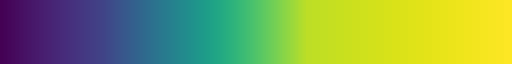

In [6]:
viridis = cm.get_cmap('viridis', 256)
newcolors1 = viridis(np.linspace(0, 0.2, 128))
newcolors2 = viridis(np.linspace(0.2, 0.9, 256))
newcolors3 = viridis(np.linspace(0.9, 1, 256))
newcolors = np.vstack((newcolors1, newcolors2, newcolors3))
cmap = ListedColormap(newcolors)
cmap.set_over(np.array([202,0,32,128]) / 255)
cmap.set_under(np.array([0,0,0,128]) / 255)
cmap

The velocity x component looks like this:

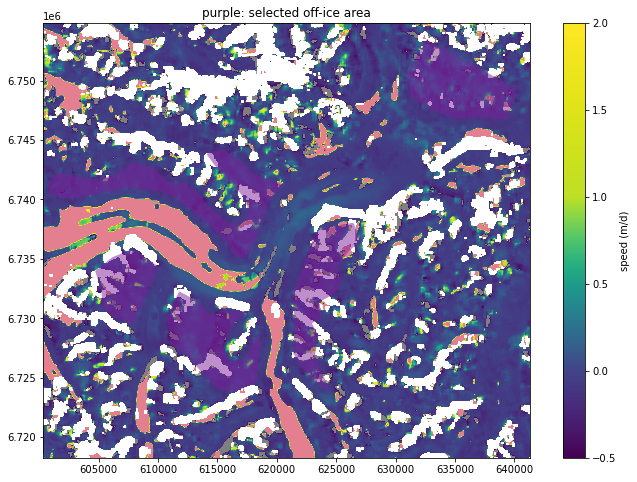

In [7]:
fig, ax0 = plt.subplots(1, 1, figsize=(12, 8))

# with rasterio.open(demo.Vx.replace('vx', 'mag')) as v_src:
#     v = v_src.read(1)
#     show(v_src, ax=ax0, vmin=0, vmax=2, cmap=cmap)

with rasterio.open(demo.Vx) as v_src:
    v = v_src.read(1)
    show(v_src, ax=ax0, vmin=-0.5, vmax=2, cmap=cmap)
    
cbar =  fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=-0.5, vmax=2), cmap=cmap), ax=ax0)
cbar.set_label('speed (m/d)')
off_ice.plot(ax=ax0, alpha=0.5, facecolor='xkcd:purple')
ax0.set_title('purple: selected off-ice area');

Running clip_static_area
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running calculate_metric_static_terrain


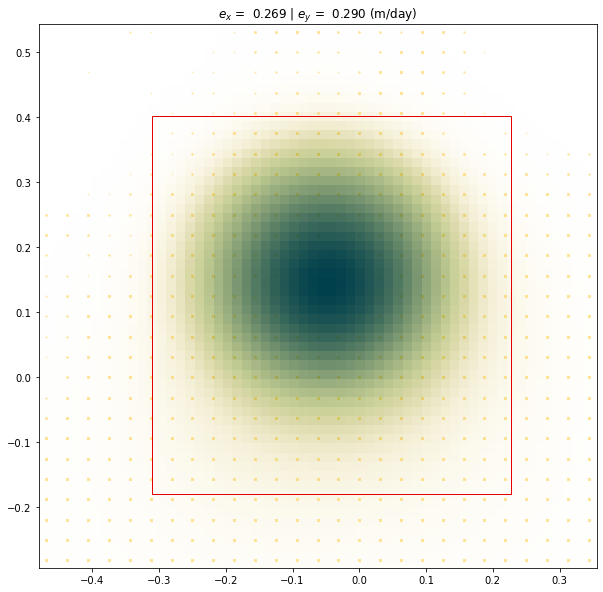

In [8]:
exp = glaft.Velocity(vxfile=demo.Vx, vyfile=demo.Vy, static_area=in_shp, kde_gridsize=60, thres_sigma=2.0)
exp.static_terrain_analysis(plot='zoomed')

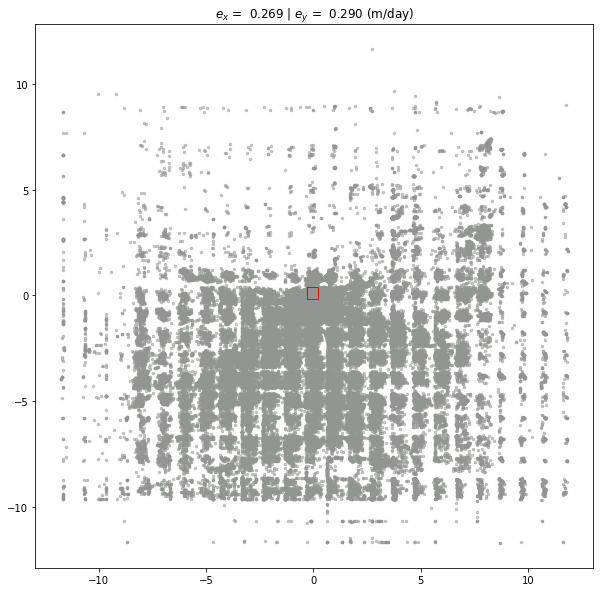

In [9]:
exp.plot_full_extent()

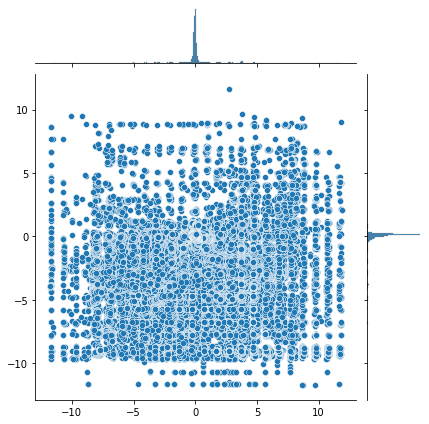

In [16]:
# sns.jointplot(data=exp.xy)
sns.jointplot(x=exp.xy[0, :], y=exp.xy[1, :], marginal_kws=dict(bins=300, ))

In [ ]:
# fig, ax1 = plt.subplots(1, 2, figsize=(15, 7))
# exp.static_terrain_analysis(plot='zoomed', ax=ax1)

Now we can call the `off_ice_errors` function from GFTT and calculate off-ice errors:

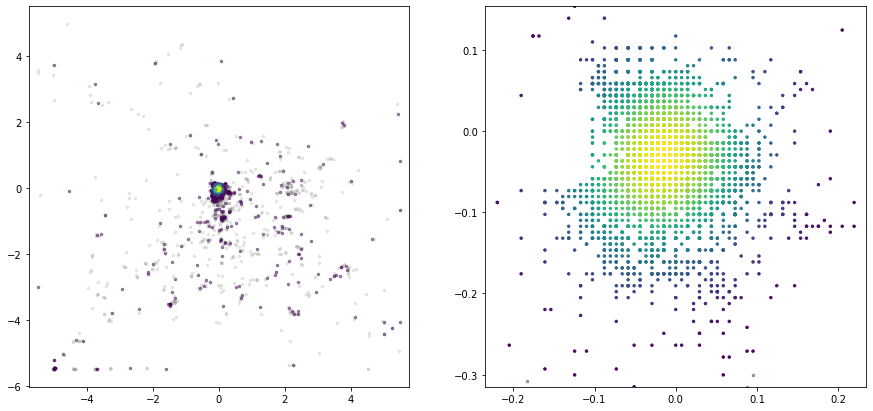

In [8]:
fig, ax1 = plt.subplots(1, 2, figsize=(15, 7))

for ax in ax1:
    ax.axis('equal')
vx, vy, z, thres_idx = glaft.off_ice_errors(vxfile=demo.Vx, vyfile=demo.Vy, off_ice_area=in_shp, ax=ax1[0])
glaft.plot_off_ice_errors(vx, vy, z, thres_idx, ax=ax1[1])


Here, x-axis is $V_x$ (m/day), y-axis is $V_y$ (m/day). We randomly select 10,000 pixels and color code them based on the Gaussian kernel density estimate, and the other pixels are plotting as gray points. Transparent color points have a kernel density below a chosen confidence level, which is 3.0 by default and corresponds to a confidence level of 99.7%. 

To see how close these points approximate a normal distribution errors are randomly distributed, we can quickly calculate how much the selected pixel account for. For a 3-sigma threshold, the non-transparent points should account for ~99.7% of all the points:

In [9]:
np.sum(thres_idx) / vx.shape

array([0.9752])

This gives us 97.5%, indicating more points falling outside of the chosen confidence interval than assumed. This is okay because the standard deviation of these points would be a conservative estimate, affected by many outliers and larger than the actual standard deviation. 

The 3-sigma error can be thus derived by finding the boundary of the selected pixels. These numbers should resemble the overall uncertainty of both on-ice and off-ice pixels, and we use them as a metric for estimating the feature tracking results. 

In [10]:
print('Vx error (3-sigma): {:5f}  m/day'.format(0.5 * (max(vx[thres_idx]) - min(vx[thres_idx]))))
print('Vy error (3-sigma): {:5f}  m/day'.format(0.5 * (max(vy[thres_idx]) - min(vy[thres_idx]))))

Vx error (3-sigma): 0.219727  m/day
Vy error (3-sigma): 0.234375  m/day


#### 3.2 Demo 2

This demo provides a bigger output figure with the error bound shown as a red box.

In [13]:
demo = df.loc[18]
demo

Date                                              LS8-20180304-20180405
Duration (days)                                                      32
Template size (px)                                                   32
Template size (m)                                                   480
Pixel spacing (px)                                                    1
Pixel spacing (m)                                                    15
Prefilter                                                           Gau
Subpixel                                           16-node oversampling
Software                                                          CARST
Vx                    /home/jovyan/Projects/PX_comparison/PX/CARST/2...
Vy                    /home/jovyan/Projects/PX_comparison/PX/CARST/2...
Name: 18, dtype: object

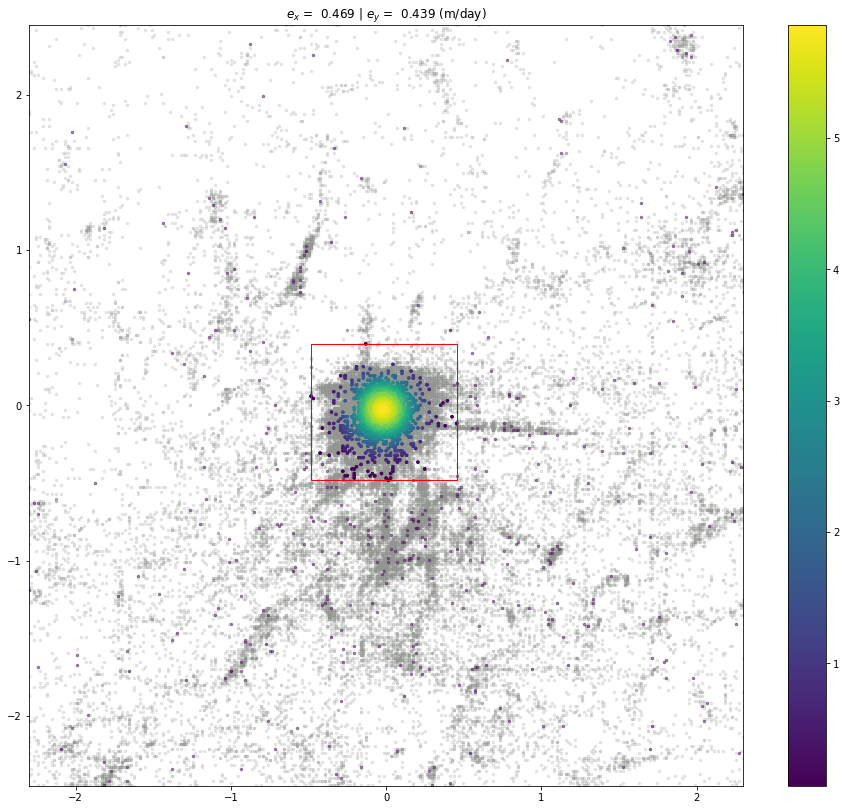

In [14]:
viridis = cm.get_cmap('viridis', 12)
pt_style = {'s': 6, 'edgecolor': None}

fig, axt = plt.subplots(1, 1, figsize=(16, 14))
vx, vy, z, thres_idx = glaft.off_ice_errors(vxfile=demo.Vx, vyfile=demo.Vy, off_ice_area=in_shp, max_n=10000, plot=True, ax=axt)

idx = thres_idx    # alias
axt.axis('equal')
tmp = axt.scatter(vx[idx], vy[idx], c=z[idx], **pt_style)
# axt.scatter(vx[~idx], vy[~idx], color=viridis(0), alpha=0.4, **pt_style)
# # axt.set_xlim((min(vx[idx]), max(vx[idx])))
# # axt.set_ylim((min(vy[idx]), max(vy[idx])))
axt.set_xlim(-2.3, 2.3)
axt.set_ylim(-2.3, 2.3)

# (left, bottom), width, height
rect = patches.Rectangle((min(vx[thres_idx]), min(vy[thres_idx])), max(vx[thres_idx]) - min(vx[thres_idx]), max(vy[thres_idx]) - min(vy[thres_idx]), 
                         linewidth=1, edgecolor='r', facecolor='none')
axt.add_patch(rect)
axt.set_title('$e_x$ = {:6.3f} | $e_y$ = {:6.3f} (m/day)'.format(0.5 * (max(vx[thres_idx]) - min(vx[thres_idx])), 
                                                                 0.5 * (max(vy[thres_idx]) - min(vy[thres_idx]))))

fig.colorbar(tmp)

#### 4. Off-ice error for 42 tests using the same Landsat 8 pair

Here's a complete list of all 42 tests with their parameter settings.

In [19]:
## Example results

# demo = df.loc[df['Date'] == 'LS8-20180304-20180405']
demo = df.loc[np.logical_and(df['Date'] == 'LS8-20180304-20180405', df['Subpixel'] != 'affine')]
# demo = df.loc[df['Date'] == 'LS8-20180802-20180818']
# demo = df.loc[np.logical_and(df['Date'] == 'LS8-20180802-20180818', df['Subpixel'] != 'affine')]
# demo = df.loc[df['Date'] == 'Sen2-20180304-20180314']
# demo = df.loc[np.logical_and(df['Date'] == 'Sen2-20180304-20180314', df['Subpixel'] != 'affine')]
# demo = df.loc[df['Date'] == 'Sen2-20180508-20180627']
# demo = df.loc[np.logical_and(df['Date'] == 'Sen2-20180508-20180627', df['Subpixel'] != 'affine')]
# There are 43-1 tests
demo

Date Chip (px) Resolution (px) Prefilter  \
18   LS8-20180304-20180405        32               1       Gau   
19   LS8-20180304-20180405        32               1      NAOF   
20   LS8-20180304-20180405        32               1      None   
21   LS8-20180304-20180405        32               4       Gau   
22   LS8-20180304-20180405        32               4      NAOF   
23   LS8-20180304-20180405        32               4      None   
24   LS8-20180304-20180405        32               8       Gau   
25   LS8-20180304-20180405        32               8      NAOF   
26   LS8-20180304-20180405        32               8      None   
27   LS8-20180304-20180405        64               1       Gau   
28   LS8-20180304-20180405        64               1      NAOF   
29   LS8-20180304-20180405        64               1      None   
30   LS8-20180304-20180405        64               4       Gau   
31   LS8-20180304-20180405        64               4      NAOF   
32   LS8-20180304-20180405        64               4      None   
33   LS8-20180304-20180405        64               8       Gau   
34   LS8-20180304-20180405        64               8      NAOF   
35   LS8-20180304-20180405        64               8      None   
72   LS8-20180304-20180405     multi              16      NAOF   
73   LS8-20180304-20180405     multi               4      NAOF   
74   LS8-20180304-20180405     multi              16       Gau   
75   LS8-20180304-20180405     multi               4       Gau   
76   LS8-20180304-20180405     multi              16      None   
77   LS8-20180304-20180405     multi               4      None   
96   LS8-20180304-20180405        31               1       Gau   
97   LS8-20180304-20180405        65               1       Gau   
104  LS8-20180304-20180405        31               1      None   
105  LS8-20180304-20180405        65               1      None   
112  LS8-20180304-20180405        31               1       LoG   
113  LS8-20180304-20180405        31               1       LoG   
124  LS8-20180304-20180405        32               4      None   
125  LS8-20180304-20180405        32               8      None   
126  LS8-20180304-20180405        64               4      None   
127  LS8-20180304-20180405        64               8      None   
128  LS8-20180304-20180405        32               4       Gau   
129  LS8-20180304-20180405        32               8       Gau   
130  LS8-20180304-20180405        64               4       Gau   
131  LS8-20180304-20180405        64               8       Gau   
132  LS8-20180304-20180405        32               4      NAOF   
133  LS8-20180304-20180405        32               8      NAOF   
134  LS8-20180304-20180405        64               4      NAOF   
135  LS8-20180304-20180405        64               8      NAOF   

                  Subpixel  Software  \
18    16-node oversampling     CARST   
19    16-node oversampling     CARST   
20    16-node oversampling     CARST   
21    16-node oversampling     CARST   
22    16-node oversampling     CARST   
23    16-node oversampling     CARST   
24    16-node oversampling     CARST   
25    16-node oversampling     CARST   
26    16-node oversampling     CARST   
27    16-node oversampling     CARST   
28    16-node oversampling     CARST   
29    16-node oversampling     CARST   
30    16-node oversampling     CARST   
31    16-node oversampling     CARST   
32    16-node oversampling     CARST   
33    16-node oversampling     CARST   
34    16-node oversampling     CARST   
35    16-node oversampling     CARST   
72   interest point groups       GIV   
73   interest point groups       GIV   
74   interest point groups       GIV   
75   interest point groups       GIV   
76   interest point groups       GIV   
77   interest point groups       GIV   
96               parabolic      Vmap   
97               parabolic      Vmap   
104              parabolic      Vmap   
105              parabolic      Vmap   
112              parabo

And here's what the data ($V_x$) look like:

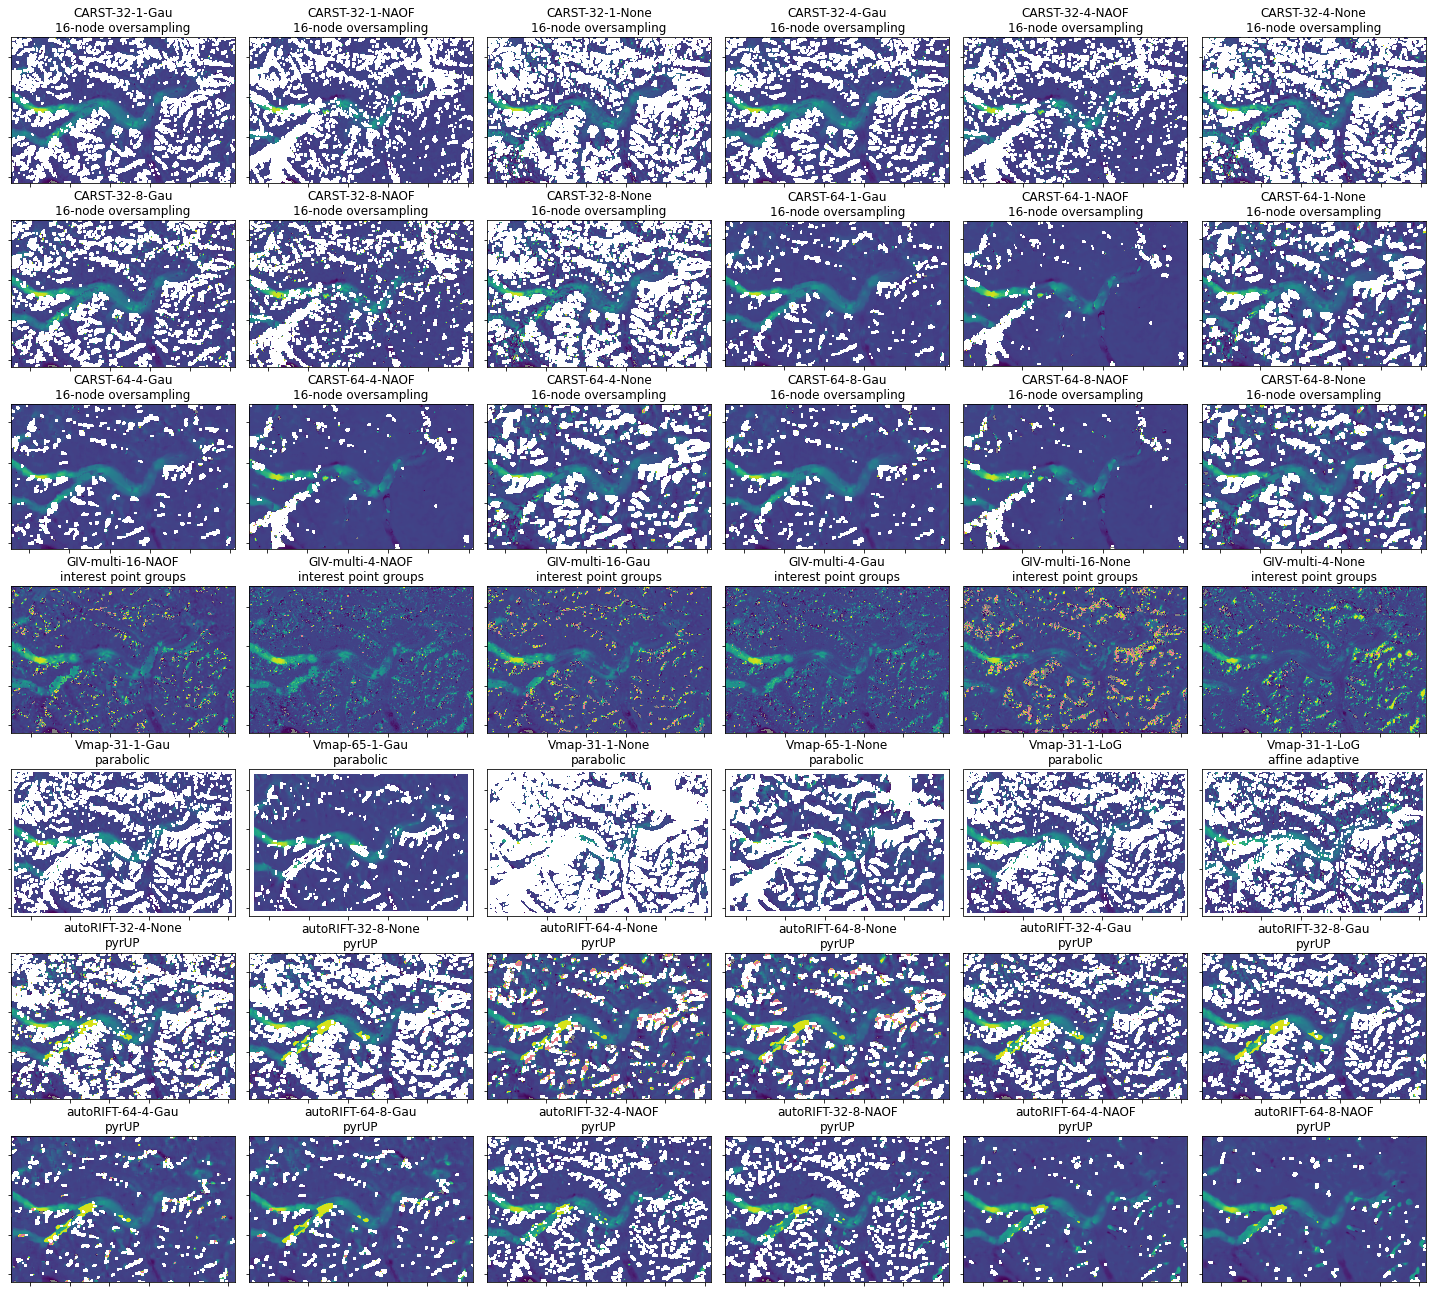

In [20]:
fig, ax3 = plt.subplots(7, 6, figsize=(20, 18))

n = 0

for idx, row in demo.iterrows():
    label = '-'.join((row.Software, row['Chip (px)'], row['Resolution (px)'], row.Prefilter)) + '\n' + row.Subpixel
    ax_sel = ax3[n // 6, n % 6]
    
    with rasterio.open(row.Vx) as vx_src:
        show(vx_src, ax=ax_sel, vmin=-0.5, vmax=2, cmap=cmap)
    ax_sel.set_title(label)
    ax_sel.xaxis.set_ticklabels([])
    ax_sel.yaxis.set_ticklabels([])
        
    n += 1
    
plt.tight_layout()
fig.patch.set_facecolor('xkcd:white')
# fig.savefig('tmp.png')

Off-ice error plots for all 42 tests:

/home/jovyan/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/home/jovyan/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


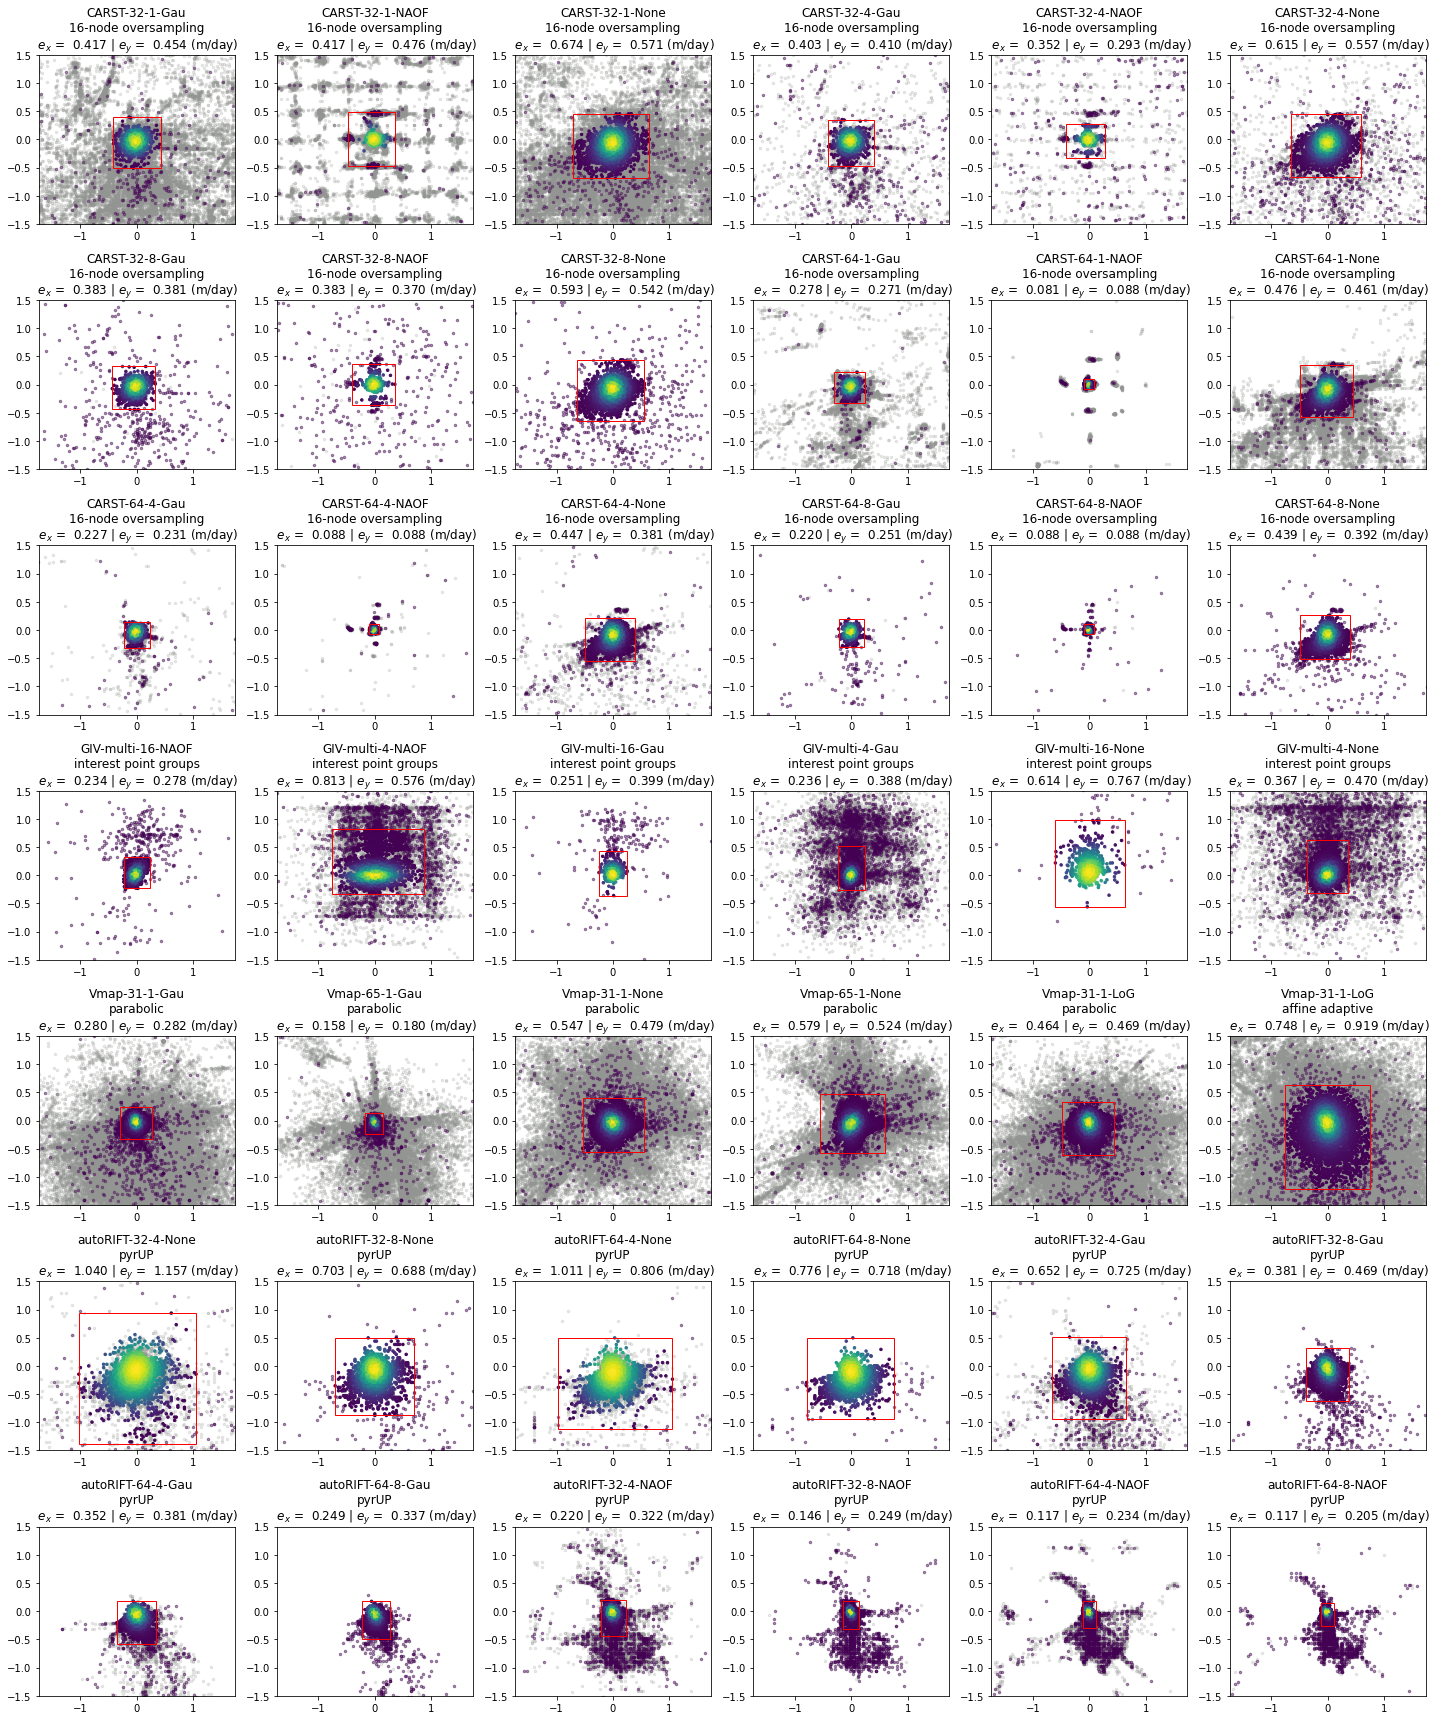

In [21]:
fig, ax4 = plt.subplots(7, 6, figsize=(20, 24))

n = 0

for idx, row in demo.iterrows():
    label = '-'.join((row.Software, row['Chip (px)'], row['Resolution (px)'], row.Prefilter)) + '\n' + row.Subpixel
    ax_sel = ax4[n // 6, n % 6]
    ax_sel.axis('equal')
    
    if row.Software == 'GIV':
        vx, vy, z, thres_idx = gftt.off_ice_errors(vxfile=row.Vx, vyfile=row.Vy, wfile=row.Vx.replace('u_', 'pkr_'), off_ice_area=in_shp, max_n=10000, plot=True, ax=ax_sel)
    else:
        vx, vy, z, thres_idx = gftt.off_ice_errors(vxfile=row.Vx, vyfile=row.Vy, off_ice_area=in_shp, max_n=10000, plot=True, ax=ax_sel)
    # gftt.plot_off_ice_errors(vx, vy, z, thres_idx, ax=ax_sel, zoom=True)
    ax_sel.set_xlim(-1.5, 1.5)
    ax_sel.set_ylim(-1.5, 1.5)

    rect = patches.Rectangle((min(vx[thres_idx]), min(vy[thres_idx])), max(vx[thres_idx]) - min(vx[thres_idx]), max(vy[thres_idx]) - min(vy[thres_idx]), 
                              linewidth=1, edgecolor='r', facecolor='none')
    ax_sel.add_patch(rect)
    
    demo.loc[idx, 'OIE-x'] = 0.5 * (max(vx[thres_idx]) - min(vx[thres_idx]))
    demo.loc[idx, 'OIE-y'] = 0.5 * (max(vy[thres_idx]) - min(vy[thres_idx]))
    label += '\n $e_x$ = {:6.3f} | $e_y$ = {:6.3f} (m/day)'.format(demo.loc[idx, 'OIE-x'], 
                                                                   demo.loc[idx, 'OIE-y'])
    ax_sel.set_title(label)
    # ax_sel.xaxis.set_ticklabels([])
    # ax_sel.yaxis.set_ticklabels([])
    

        
    n += 1
    
    
plt.tight_layout()
fig.patch.set_facecolor('xkcd:white')
# fig.savefig('tmp.png')

Results are attached to the right of the metadata sheet. (`OIE-x` and `OIE-y`)

In [22]:
# demo.to_csv('../results_agu21.csv', index=False)
demo

Date Chip (px) Resolution (px) Prefilter  \
18   LS8-20180304-20180405        32               1       Gau   
19   LS8-20180304-20180405        32               1      NAOF   
20   LS8-20180304-20180405        32               1      None   
21   LS8-20180304-20180405        32               4       Gau   
22   LS8-20180304-20180405        32               4      NAOF   
23   LS8-20180304-20180405        32               4      None   
24   LS8-20180304-20180405        32               8       Gau   
25   LS8-20180304-20180405        32               8      NAOF   
26   LS8-20180304-20180405        32               8      None   
27   LS8-20180304-20180405        64               1       Gau   
28   LS8-20180304-20180405        64               1      NAOF   
29   LS8-20180304-20180405        64               1      None   
30   LS8-20180304-20180405        64               4       Gau   
31   LS8-20180304-20180405        64               4      NAOF   
32   LS8-20180304-20180405        64               4      None   
33   LS8-20180304-20180405        64               8       Gau   
34   LS8-20180304-20180405        64               8      NAOF   
35   LS8-20180304-20180405        64               8      None   
72   LS8-20180304-20180405     multi              16      NAOF   
73   LS8-20180304-20180405     multi               4      NAOF   
74   LS8-20180304-20180405     multi              16       Gau   
75   LS8-20180304-20180405     multi               4       Gau   
76   LS8-20180304-20180405     multi              16      None   
77   LS8-20180304-20180405     multi               4      None   
96   LS8-20180304-20180405        31               1       Gau   
97   LS8-20180304-20180405        65               1       Gau   
104  LS8-20180304-20180405        31               1      None   
105  LS8-20180304-20180405        65               1      None   
112  LS8-20180304-20180405        31               1       LoG   
113  LS8-20180304-20180405        31               1       LoG   
124  LS8-20180304-20180405        32               4      None   
125  LS8-20180304-20180405        32               8      None   
126  LS8-20180304-20180405        64               4      None   
127  LS8-20180304-20180405        64               8      None   
128  LS8-20180304-20180405        32               4       Gau   
129  LS8-20180304-20180405        32               8       Gau   
130  LS8-20180304-20180405        64               4       Gau   
131  LS8-20180304-20180405        64               8       Gau   
132  LS8-20180304-20180405        32               4      NAOF   
133  LS8-20180304-20180405        32               8      NAOF   
134  LS8-20180304-20180405        64               4      NAOF   
135  LS8-20180304-20180405        64               8      NAOF   

                  Subpixel  Software  \
18    16-node oversampling     CARST   
19    16-node oversampling     CARST   
20    16-node oversampling     CARST   
21    16-node oversampling     CARST   
22    16-node oversampling     CARST   
23    16-node oversampling     CARST   
24    16-node oversampling     CARST   
25    16-node oversampling     CARST   
26    16-node oversampling     CARST   
27    16-node oversampling     CARST   
28    16-node oversampling     CARST   
29    16-node oversampling     CARST   
30    16-node oversampling     CARST   
31    16-node oversampling     CARST   
32    16-node oversampling     CARST   
33    16-node oversampling     CARST   
34    16-node oversampling     CARST   
35    16-node oversampling     CARST   
72   interest point groups       GIV   
73   interest point groups       GIV   
74   interest point groups       GIV   
75   interest point groups       GIV   
76   interest point groups       GIV   
77   interest point groups       GIV   
96               parabolic      Vmap   
97               parabolic      Vmap   
104              parabolic      Vmap   
105              parabolic      Vmap   
112              parabo

And here's another figure showing the full extent of the off-ice area velocity plot.

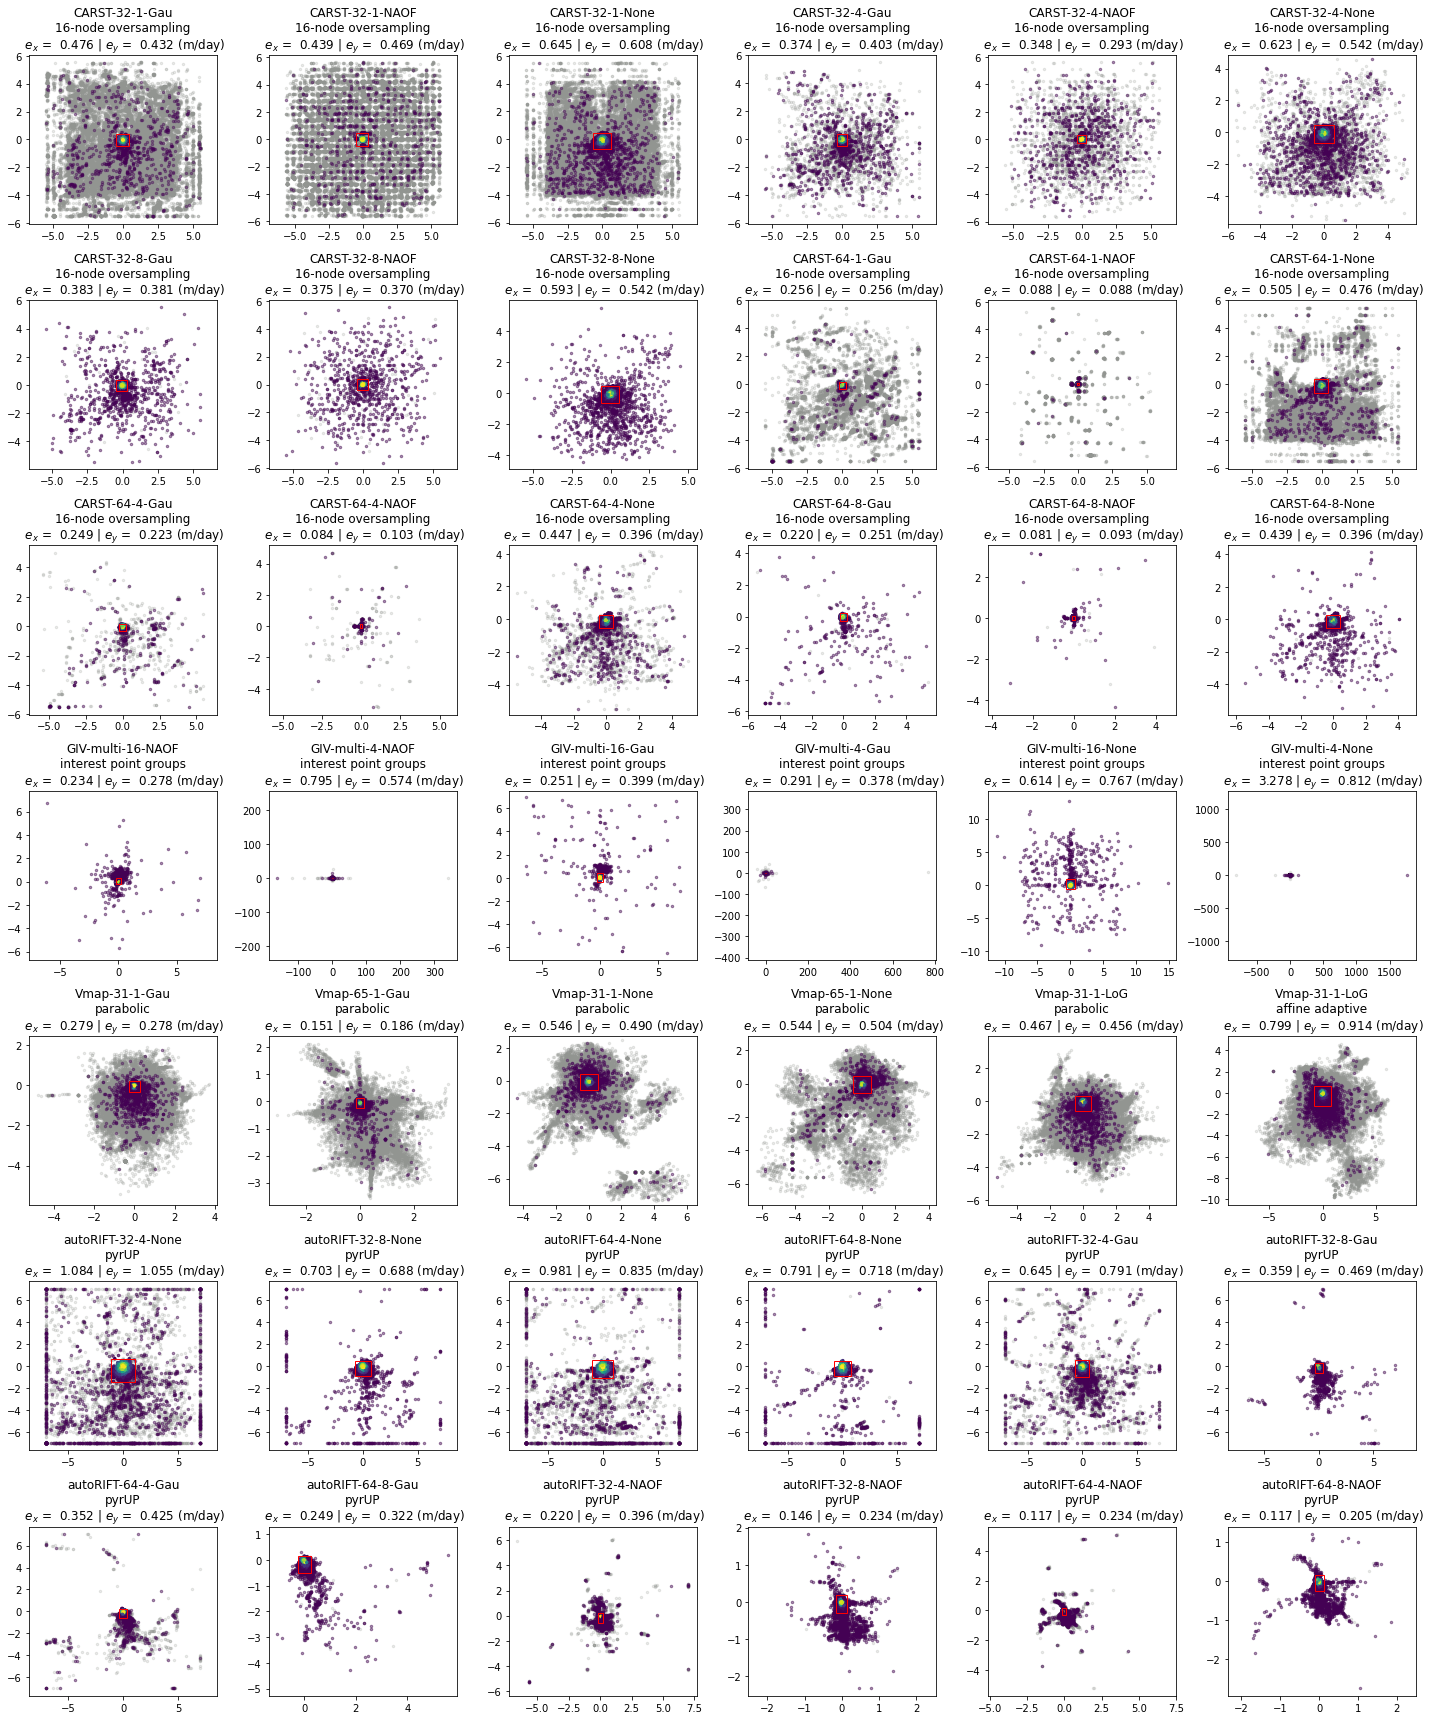

In [22]:
fig, ax5 = plt.subplots(7, 6, figsize=(20, 24))

n = 0

for idx, row in demo.iterrows():
    label = '-'.join((row.Software, row['Chip (px)'], row['Resolution (px)'], row.Prefilter)) + '\n' + row.Subpixel
    ax_sel = ax5[n // 6, n % 6]
    ax_sel.axis('equal')

    if row.Software == 'GIV':
        vx, vy, z, thres_idx = gftt.off_ice_errors(vxfile=row.Vx, vyfile=row.Vy, wfile=row.Vx.replace('u_', 'pkr_'), off_ice_area=in_shp, max_n=10000, plot=True, ax=ax_sel)
    else:
        vx, vy, z, thres_idx = gftt.off_ice_errors(vxfile=row.Vx, vyfile=row.Vy, off_ice_area=in_shp, max_n=10000, plot=True, ax=ax_sel)
    # gftt.plot_off_ice_errors(vx, vy, z, thres_idx, ax=ax_sel, zoom=True)
    # ax_sel.set_xlim(-0.5, 0.5)
    # ax_sel.set_ylim(-0.5, 0.5)
    
    rect = patches.Rectangle((min(vx[thres_idx]), min(vy[thres_idx])), max(vx[thres_idx]) - min(vx[thres_idx]), max(vy[thres_idx]) - min(vy[thres_idx]), 
                              linewidth=1, edgecolor='r', facecolor='none')
    ax_sel.add_patch(rect)
    label += '\n $e_x$ = {:6.3f} | $e_y$ = {:6.3f} (m/day)'.format(0.5 * (max(vx[thres_idx]) - min(vx[thres_idx])), 
                                                                   0.5 * (max(vy[thres_idx]) - min(vy[thres_idx])))
    ax_sel.set_title(label)
    # ax_sel.xaxis.set_ticklabels([])
    # ax_sel.yaxis.set_ticklabels([])
        
    n += 1
    
plt.tight_layout()
fig.patch.set_facecolor('xkcd:white')

#### 5. AGU 2021 poster, Figure 2

Here shows the script to make Figure in the AGU 2021 poster. We use only 9 tests for readability.

In [5]:
demo = df.loc[[18, 19, 20, 74,75, 96, 104, 128, 132]]
demo

Date Chip (px) Resolution (px) Prefilter  \
18   LS8-20180304-20180405        32               1       Gau   
19   LS8-20180304-20180405        32               1      NAOF   
20   LS8-20180304-20180405        32               1      None   
74   LS8-20180304-20180405     multi              16       Gau   
75   LS8-20180304-20180405     multi               4       Gau   
96   LS8-20180304-20180405        31               1       Gau   
104  LS8-20180304-20180405        31               1      None   
128  LS8-20180304-20180405        32               4       Gau   
132  LS8-20180304-20180405        32               4      NAOF   

                  Subpixel  Software  \
18    16-node oversampling     CARST   
19    16-node oversampling     CARST   
20    16-node oversampling     CARST   
74   interest point groups       GIV   
75   interest point groups       GIV   
96               parabolic      Vmap   
104              parabolic      Vmap   
128                  pyrUP  autoRIFT   
132                  pyrUP  autoRIFT   

                                                    Vx  \
18   /home/jovyan/Projects/PX_comparison/PX/CARST/2...   
19   /home/jovyan/Projects/PX_comparison/PX/CARST/2...   
20   /home/jovyan/Projects/PX_comparison/PX/CARST/2...   
74   /home/jovyan/Projects/PX_comparison/PX/GIV/u_l...   
75   /home/jovyan/Projects/PX_comparison/PX/GIV/u_l...   
96   /home/jovyan/Projects/PX_comparison/PX/Vmap/pa...   
104  /home/jovyan/Projects/PX_comparison/PX/Vmap/pa...   
128  /home/jovyan/Projects/PX_comparison/PX/autoRIF...   
132  /home/jovyan/Projects/PX_comparison/PX/autoRIF...   

                                                    Vy  
18   /home/jovyan/Projects/PX_comparison/PX/CARST/2...  
19   /home/jovyan/Projects/PX_comparison/PX/CARST/2...  
20   /home/jovyan/Projects/PX_comparison/PX/CARST/2...  
74   /home/jovyan/Projects/PX_comparison/PX/GIV/v_l...  
75   /home/jovyan/Projects/PX_comparison/PX/GIV/v_l...  
96   /home/jovyan/Projects/PX_comparison/PX/Vmap/pa...  
104  /home/jovyan/Projects/PX_comparison/PX/Vmap/pa...  
128  /home/jovyan/Projects/PX_comparison/PX/autoRIF...  
132  /home/jovyan/Projects/PX_comparison/PX/autoRIF...

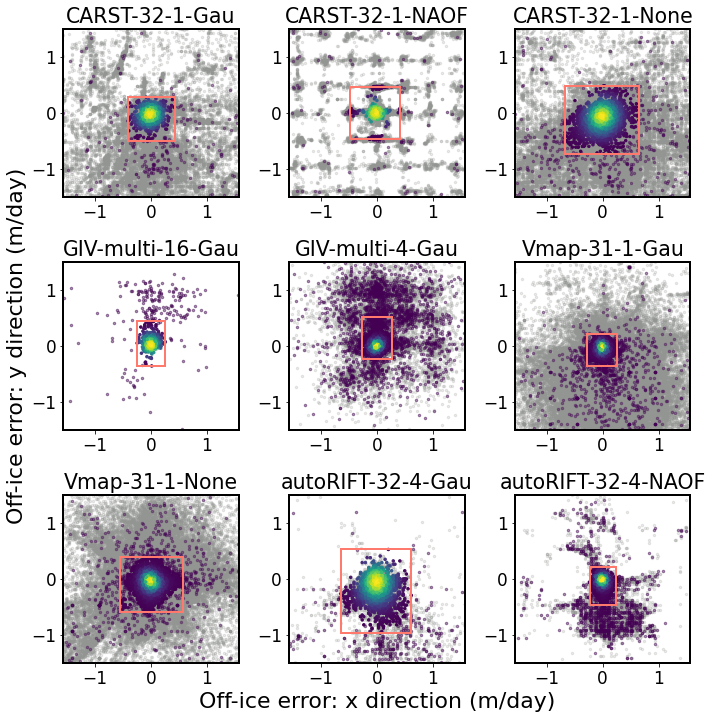

In [15]:
font = {'size'   : 17}
matplotlib.rc('font', **font)
axes_settings = {'linewidth'   : 2}
# axes_settings = {'linewidth'   : 2, 'labelsize': 14}
matplotlib.rc('axes', **axes_settings)

fig, ax_agu = plt.subplots(3, 3, figsize=(10, 10.3))

n = 0

for idx, row in demo.iterrows():
    # label = '-'.join((row.Software, row['Chip (px)'], row['Resolution (px)'], row.Prefilter)) + '\n' + row.Subpixel
    label = '-'.join((row.Software, row['Chip (px)'], row['Resolution (px)'], row.Prefilter))
    ax_sel = ax_agu[n // 3, n % 3]
    ax_sel.axis('equal')
    
    if row.Software == 'GIV':
        vx, vy, z, thres_idx = gftt.off_ice_errors(vxfile=row.Vx, vyfile=row.Vy, wfile=row.Vx.replace('u_', 'pkr_'), off_ice_area=in_shp, max_n=10000, plot=True, ax=ax_sel)
    else:
        vx, vy, z, thres_idx = gftt.off_ice_errors(vxfile=row.Vx, vyfile=row.Vy, off_ice_area=in_shp, max_n=10000, plot=True, ax=ax_sel)
    # gftt.plot_off_ice_errors(vx, vy, z, thres_idx, ax=ax_sel, zoom=True)
    ax_sel.set_xlim(-1.5, 1.5)
    ax_sel.set_ylim(-1.5, 1.5)

    rect = patches.Rectangle((min(vx[thres_idx]), min(vy[thres_idx])), max(vx[thres_idx]) - min(vx[thres_idx]), max(vy[thres_idx]) - min(vy[thres_idx]), 
                              linewidth=2, edgecolor='xkcd:salmon', facecolor='none')
    ax_sel.add_patch(rect)
    
    demo.loc[idx, 'OIE-x'] = 0.5 * (max(vx[thres_idx]) - min(vx[thres_idx]))
    demo.loc[idx, 'OIE-y'] = 0.5 * (max(vy[thres_idx]) - min(vy[thres_idx]))
    # label += '\n $e_x$ = {:6.3f} | $e_y$ = {:6.3f} '.format(demo.loc[idx, 'OIE-x'], 
    #                                                         demo.loc[idx, 'OIE-y'])
    ax_sel.set_title(label)
    # ax_sel.xaxis.set_ticklabels([])
    # ax_sel.yaxis.set_ticklabels([])
    

        
    n += 1
    
    
ax_agu[1, 0].set_ylabel('Off-ice error: y direction (m/day)', fontsize=22)
ax_agu[2, 1].set_xlabel('Off-ice error: x direction (m/day)', fontsize=22)
    
plt.tight_layout()
fig.patch.set_facecolor('xkcd:white')
# fig.savefig('OIE-9panels-AGU21_updated.png', dpi=450)